# MNIST - Hello World for Deep Learning

In [29]:
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import copy
from sklearn.metrics import confusion_matrix
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [19]:
numb_batch = 64

T = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_data = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=T)
val_data = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=T)

train_dl = torch.utils.data.DataLoader(train_data, batch_size=numb_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size=numb_batch)

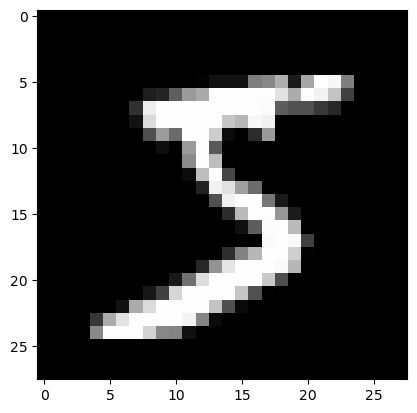

In [21]:
plt.imshow(train_data[0][0][0], cmap='gray')

In [22]:
def create_lenet():
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),

        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),

        nn.Flatten(),
        nn.Linear(400, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model


In [23]:
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct*100/total


In [24]:
def train(numb_epoch=3, lr=1e-3, device="cpu"):
    accuracies = []
    cnn = create_lenet().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0

    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, val_dl))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        print("Epoch: ", epoch+1, "Accuracy: ", accuracy, "%")
    plt.plot(accuracies)
    return best_model

In [25]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")


Saving Best Model with Accuracy:  95.45999908447266
Epoch:  1 Accuracy:  95.45999908447266 %
Saving Best Model with Accuracy:  97.22000122070312
Epoch:  2 Accuracy:  97.22000122070312 %
Saving Best Model with Accuracy:  97.98999786376953
Epoch:  3 Accuracy:  97.98999786376953 %
Saving Best Model with Accuracy:  98.26000213623047
Epoch:  4 Accuracy:  98.26000213623047 %
Saving Best Model with Accuracy:  98.56999969482422
Epoch:  5 Accuracy:  98.56999969482422 %
Saving Best Model with Accuracy:  98.7699966430664
Epoch:  6 Accuracy:  98.7699966430664 %
Saving Best Model with Accuracy:  98.80999755859375
Epoch:  7 Accuracy:  98.80999755859375 %
Epoch:  8 Accuracy:  98.76000213623047 %
Epoch:  9 Accuracy:  98.72000122070312 %
Epoch:  10 Accuracy:  98.69999694824219 %
Epoch:  11 Accuracy:  98.7699966430664 %
Epoch:  12 Accuracy:  98.76000213623047 %
Epoch:  13 Accuracy:  98.79000091552734 %
Epoch:  14 Accuracy:  98.80000305175781 %
Saving Best Model with Accuracy:  98.88999938964844
Epoch:  

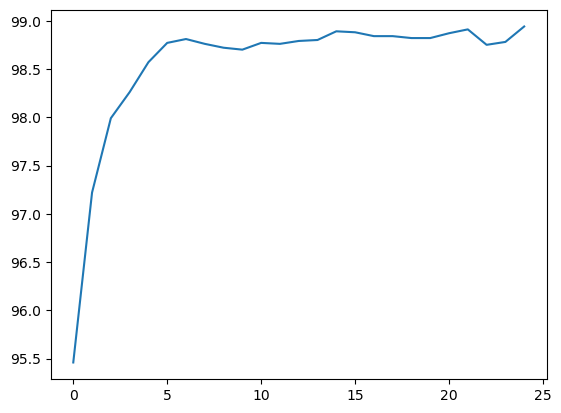

In [26]:
lenet = train(25, device=device)

In [27]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)


In [30]:
y_pred, y_true = predict_dl(lenet, val_dl)
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))

,0,1,2,3,4,5,6,7,8,9
0,977,0,0,0,0,0,1,1,1,0
1,0,1135,0,0,0,0,0,0,0,0
2,3,1,1023,1,0,0,1,2,1,0
3,1,0,6,997,0,2,0,3,1,0
4,0,0,0,0,963,0,5,1,2,11
5,3,0,0,6,0,881,1,0,1,0
6,4,4,0,0,1,0,949,0,0,0
7,0,4,2,0,0,0,0,1021,1,0
8,2,1,3,0,0,0,1,1,964,2
9,0,1,0,0,11,6,1,3,3,984


In [31]:
def inference(path, model, device):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        img = Image.open(f).convert(mode="L")
        img = img.resize((28,28))
        x = (255 - np.expand_dims(np.array(img), -1))/255
    with torch.no_grad():
        pred = model(torch.unsqueeze(T(x), axis=0).float().to(device))
        return F.softmax(pred, dim=-1).cpu().numpy()

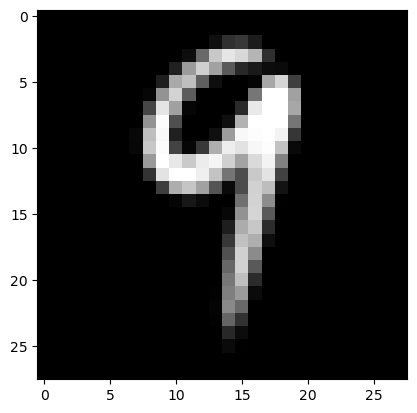

In [33]:
path = "https://static.vecteezy.com/system/resources/previews/008/289/065/original/nine-number-nine-design-9th-birthday-logo-icon-design-9-number-names-typography-design-9-years-anniversary-celebration-logotype-black-lettering-numbers-brush-drawing-hand-drawn-sketch-vector.jpg"
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f).convert(mode="L")
    img = img.resize((28,28))
    x = (255 - np.expand_dims(np.array(img), -1))/255

plt.imshow(x.squeeze(-1), cmap='gray')

In [34]:
pred = inference(path, lenet, device=device)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx}, Prob: {pred[0][pred_idx]*100} %")

Predicted: 4, Prob: 99.80494976043701 %
